In [52]:
import pandas
import librosa
import numpy
import pronouncing
import audioread
import numpy as np
import IPython.display as ipd
from librosa import display
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import importlib
importlib.reload(librosa)

<module 'librosa' from '/home/alex/.local/lib/python3.8/site-packages/librosa/__init__.py'>

In [2]:
train_data = pandas.read_csv("cv-valid-train.csv").to_numpy()


In [3]:
samples, sampling_rate = librosa.load("cv-valid-train/" + train_data[0][0], sr = 48000)
duration = len(samples) / sampling_rate
print(samples, duration, sampling_rate)
print(train_data[0][1])

def get_character_count(text):
    filtered = [c.lower() for c in text if c.isalpha()]
    return len(filtered)

def get_characters(text):
    return [c.lower() for c in text if c.isalpha()]

print(get_character_count(train_data[0][1]))

/home/alex/.local/lib/python3.8/site-packages/librosa/core/audio.py:163: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[0.         0.         0.         ... 0.00039673 0.00079346 0.00076294] 4.104 48000
learn to recognize omens and follow them the old king had said
51


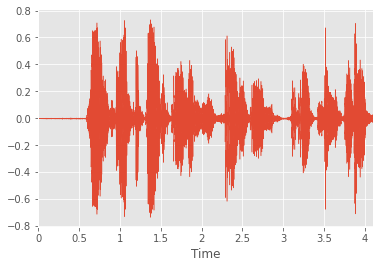

In [4]:
plt.figure()
librosa.display.waveplot(y = samples, sr = sampling_rate)
plt.show()

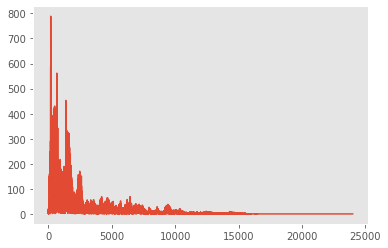

In [5]:
def compute_fft(audio, sampling_rate):
    fft = numpy.abs(numpy.fft.fft(audio))
    freq = numpy.abs(numpy.fft.fftfreq(len(audio), d = (1.0/sampling_rate)))
    audio_length = len(audio)
    fft = fft[:(audio_length // 2)]
    freq = freq[:(audio_length // 2)]
    return fft, freq

def fft_plot(fft, freq):
    fig, ax = plt.subplots()
    ax.plot(freq, fft)
    plt.grid()
    return plt.show()

fft, freq = compute_fft(samples, sampling_rate)
fft_plot(fft, freq)

In [6]:
def spectrogram(samples, sample_rate, stride_ms = 10.0, 
                          window_ms = 20.0, max_freq = 24000, eps = 1e-14):

    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = numpy.lib.stride_tricks.as_strided(samples, 
                                          shape = nshape, strides = nstrides)
    
    assert numpy.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = numpy.hanning(window_size)[:, None]
    fft = numpy.fft.rfft(windows * weighting, axis=0)
    fft = numpy.absolute(fft)
    fft = fft**2
    
    
    scale = numpy.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale
    
    # Prepare fft frequency list
    freqs = float(sample_rate) / window_size * numpy.arange(fft.shape[0])
    
    # Compute spectrogram feature
    ind = numpy.where(freqs <= max_freq)[0][-1] + 1
    specgram = numpy.log(fft[:ind, :] + eps)
    return specgram
    
specgram = spectrogram(samples, sampling_rate)
specgram = numpy.flip(specgram, axis = 0)

(481, 409)


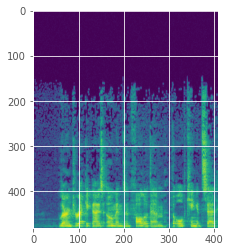

In [7]:
print(specgram.shape)
plt.imshow(specgram)

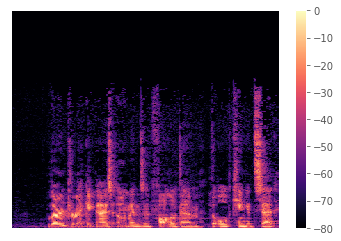

In [8]:
plt.figure()
librosa.display.specshow(librosa.amplitude_to_db(numpy.abs(librosa.stft(samples)), ref=numpy.max))
plt.colorbar()

In [9]:
def cos_sim(a,b):
    return numpy.dot(a,b) / (numpy.linalg.norm(a) * numpy.linalg.norm(b))

def magnitude_diff(a,b):
    res = numpy.linalg.norm(a) / numpy.linalg.norm(b)
    if (res < 1):
        res = 1.0 / res
    return res

def magnitude_raw_diff(a,b):
    return numpy.linalg.norm(a) / numpy.linalg.norm(b)

def sim_score(a,b):
    return 1 - ((1 - cos_sim(a,b)) * (4 * magnitude_diff(a,b)))

def compute_boundaries(specgram, threshold):
    columns = specgram.shape[1]
    res = []
    current_i = -1
    for i in range(columns - 1):
        current_column_0 = specgram[:,i]
        current_column_1 = specgram[:,(i + 1)]
        sim = sim_score(current_column_0, current_column_1)
        if ((sim < threshold) and ((i - current_i) > 2)):
            res.append(i)
            current_i = i
    return res

boundaries = compute_boundaries(specgram, 0.99785)
print(boundaries)
print(len(boundaries))

[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59, 62, 65, 68, 71, 74, 77, 80, 83, 86, 89, 92, 95, 98, 101, 104, 107, 110, 113, 116, 119, 122, 125, 128, 131, 134, 137, 140, 143, 146, 149, 152, 155, 158, 161, 164, 167, 170, 173, 176, 179, 182, 185, 188, 191, 194, 197, 200, 203, 206, 209, 212, 215, 218, 221, 224, 227, 230, 233, 236, 239, 242, 245, 248, 251, 254, 257, 260, 263, 266, 269, 272, 275, 278, 281, 284, 287, 290, 293, 296, 299, 302, 305, 308, 311, 314, 317, 320, 323, 326, 329, 332, 335, 338, 341, 344, 347, 350, 353, 356, 359, 362, 365, 368, 371, 374, 377, 380, 383, 386, 389, 392, 395, 398, 401, 404, 407]
136


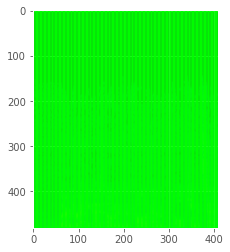

In [10]:
fig, ax = plt.subplots()
ax.imshow(specgram)
lims = ax.get_ylim()

ax.vlines(boundaries, lims[0], lims[1], color='lime', alpha=0.9,linewidth=2, label='Beats')

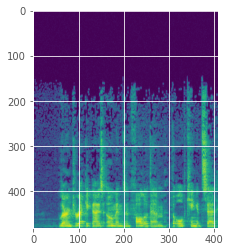

In [11]:
plt.imshow(specgram)

In [12]:
def detect_speech_boundary(specgram, threshold, spacing):
    columns = specgram.shape[1]
    res = []
    current_i = -1
    in_speech = 0
    for i in range(columns - 1):
        current_column_0 = specgram[:,i]
        current_column_1 = specgram[:,(i + 1)]
        sim = magnitude_raw_diff(current_column_0, current_column_1)
        if ((sim < threshold) and ((i - current_i) > spacing) and (in_speech == 0)):
            res.append(i)
            current_i = i
            in_speech = 1
        elif ((in_speech == 1) and (sim > (1.0 / threshold)) and ((i - current_i) > spacing)):
            #res.append(i)
            #current_i = i
            in_speech = 0            
    return res    

def is_quiet(column, threshold):
    return column.mean() < threshold

def list_does_not_contain_range(res, lower, upper):
    for i in range(lower, upper + 1):
        if (i in res):
            return False
    return True

def compute_boundaries_list(specgram, n):
    columns = specgram.shape[1]
    sim_score_list = []
    res = []
    current_i = -1
    for i in range(columns - 1):
        current_column_0 = specgram[:,i]
        current_column_1 = specgram[:,(i + 1)]
        sim = sim_score(current_column_0, current_column_1)
        sim_score_list.append([sim, i])
    sim_score_list.sort(key=lambda item: item[0])
    i = 0
    while (len(res) < n):
        item = sim_score_list[i][1]
        if (list_does_not_contain_range(res, item - 1, item + 1)):
            res.append(item)
        i = i + 1
    res.sort()
    return res

def get_speech_list(specgram, threshold):
    columns = specgram.shape[1]
    item_list = []
    for i in range(columns):
        sub_array = specgram[:,i][425:]
        if (not is_quiet(sub_array, threshold)):
            item_list.append(i)
    return item_list

def get_loudness_threshold(specgram):
    spec_range = specgram[425:]
    #return (numpy.max(spec_range) + (2*numpy.min(spec_range)) + (4 * numpy.mean(spec_range))) / 7.0
    return (numpy.median(spec_range) + numpy.mean(spec_range)) / 2.0

def get_speech_samples(samples, sampling_rate, specgram, threshold, window_width = 20.0, stride_length = 10.0):
    window_width = int(0.001 * sampling_rate * window_width)
    stride_length = int(0.001 * sampling_rate * stride_length)
    
    new_samples = []
    item_list = get_speech_list(specgram, threshold)
    last_high_range = -1
    for i in item_list:
        low_range = i * stride_length
        high_range = low_range + window_width
        if (last_high_range > low_range):
            low_range = last_high_range + 1
        sub_samples = samples[low_range:high_range]
        new_samples = new_samples + sub_samples.tolist()
        last_high_range = high_range
    return numpy.array(new_samples, dtype=float)
        
def strip_nonspeech(specgram, threshold):
    item_list = get_speech_list(specgram, threshold)
    return specgram[:, item_list]

def get_specgram_clips(specgram, item_list):
    res = []
    for i in range(len(item_list) - 1):
        item_start = item_list[i] + 1
        item_end = item_list[i + 1] + 1
        res.append(specgram[:, item_start:item_end])
    return res

def get_audio_clips(samples, sampling_rate, item_list, window_width = 20.0, stride_length = 10.0):
    window_width = int(0.001 * sampling_rate * window_width)
    stride_length = int(0.001 * sampling_rate * stride_length)
    res = []
    for i in range(len(item_list) - 1):
        item_start = item_list[i] + 1
        item_end = item_list[i + 1] + 10
        sample_start = item_start * stride_length
        #sample_end = sample_start + window_width
        sample_end = item_end * stride_length
        res.append(samples[sample_start:sample_end].repeat(1))
    return res

def process_audio_demo(row):
    samples, sampling_rate = librosa.load("cv-valid-train/" + row[0], sr = 48000)
    duration = len(samples) / sampling_rate
    print(samples, duration, sampling_rate)
    print(row[1])

    letter_count = get_character_count(row[1])
    print(letter_count)
    fft, freq = compute_fft(samples, sampling_rate)
    
    specgram = spectrogram(samples, sampling_rate)
    specgram = numpy.flip(specgram, axis = 0)

    loudness_threshold = get_loudness_threshold(specgram)
    stripped_specgram = strip_nonspeech(specgram, loudness_threshold)
    stripped_speech_sample = get_speech_samples(samples, sampling_rate, specgram, loudness_threshold)
    
    #boundary_start = compute_boundaries(stripped_specgram, 0.988)
    #boundary_start = compute_boundaries_list(stripped_specgram, letter_count + 1)
    #specgram_letter_clips = get_specgram_clips(stripped_specgram, boundary_start)
    #audio_letter_clips = get_audio_clips(stripped_speech_sample, sampling_rate, boundary_start)
    
    #print(boundary_start)
    #print(len(boundary_start))
    #print(get_loudness(specgram))
    #print(len(audio_letter_clips))
    
    
    fig, ax = plt.subplots()
    ax.imshow(specgram)
    lims = ax.get_ylim()

    #ax.vlines(boundary_start, lims[0], lims[1], color='lime', alpha=0.9,linewidth=2, label='Beats')
    #ax.vlines(boundary_end, lims[0], lims[1], color='lime', alpha=0.9,linewidth=2, label='Beats')
    #return ipd.Audio("cv-valid-train/" + row[0])
    return ipd.Audio(stripped_speech_sample, rate=sampling_rate)

def interpolate_specgram_sample(specgram, desired_width):
    res = []
    columns = specgram.shape[1]
    for row in specgram:
        #print(numpy.arange(desired_width) / desired_width)
        #print(numpy.arange(columns) / columns)
        res.append(numpy.interp(numpy.arange(desired_width) / desired_width, numpy.arange(columns) / columns, row))
    return numpy.array(res, dtype=float)

def __audioread_load(path, offset, duration, dtype):
    """Load an audio buffer using audioread.

    This loads one block at a time, and then concatenates the results.
    """

    y = []
    with audioread.audio_open(path) as input_file:
        sr_native = input_file.samplerate
        n_channels = input_file.channels

        s_start = int(np.round(sr_native * offset)) * n_channels

        if duration is None:
            s_end = np.inf
        else:
            s_end = s_start + (int(np.round(sr_native * duration)) * n_channels)

        n = 0

        for frame in input_file:
            frame = librosa.util.buf_to_float(frame, dtype=dtype)
            n_prev = n
            n = n + len(frame)

            if n < s_start:
                # offset is after the current frame
                # keep reading
                continue

            if s_end < n_prev:
                # we're off the end.  stop reading
                break

            if s_end < n:
                # the end is in this frame.  crop.
                frame = frame[: s_end - n_prev]

            if n_prev <= s_start <= n:
                # beginning is in this frame
                frame = frame[(s_start - n_prev) :]

            # tack on the current frame
            y.append(frame)

    if y:
        y = np.concatenate(y)
        if n_channels > 1:
            y = y.reshape((-1, n_channels)).T
    else:
        y = np.empty(0, dtype=dtype)

    return y, sr_native


def process_audio(row):
    res = []
    samples, sampling_rate = librosa.load_mp3("cv-valid-train/" + row[0], sr = 48000)
    duration = len(samples) / sampling_rate

    letters = get_characters(row[1])
    letter_count = len(letters)
    
    fft, freq = compute_fft(samples, sampling_rate)
    
    specgram = spectrogram(samples, sampling_rate)
    specgram = numpy.flip(specgram, axis = 0)

    loudness_threshold = get_loudness_threshold(specgram)
    stripped_specgram = strip_nonspeech(specgram, loudness_threshold)
    
    boundary_start = compute_boundaries_list(stripped_specgram, letter_count + 1)
    specgram_letter_clips = get_specgram_clips(stripped_specgram, boundary_start)
    
    
    for letter, specgram_clip in zip(letters, specgram_letter_clips):
        specgram_clip_resampled = interpolate_specgram_sample(specgram_clip, 10)
        res.append([letter, specgram_clip_resampled])
    return res
#__audioread_load("cv-valid-train/" + train_data[0][0], 0, None, np.float32)
#%time audioread.audio_open("cv-valid-train/" + train_data[0][0])
#for i in range(10):
#    print(i)
#    %time res = process_audio(train_data[i])
process_audio(train_data[705])

#interpolate_specgram_sample(numpy.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]], dtype=float), 10)

[['t',
  array([[-31.75488166, -31.84037961, -31.92587757, ..., -32.18237143,
          -32.18237143, -32.18237143],
         [-31.53838776, -31.65391294, -31.76943812, ..., -32.11601366,
          -32.11601366, -32.11601366],
         [-31.97019081, -31.99347442, -32.01675802, ..., -32.08660884,
          -32.08660884, -32.08660884],
         ...,
         [-14.11371809, -14.05837128, -14.00302447, ..., -13.83698403,
          -13.83698403, -13.83698403],
         [-17.17243846, -17.1039553 , -17.03547214, ..., -16.83002266,
          -16.83002266, -16.83002266],
         [-26.3950858 , -25.31042384, -24.22576188, ..., -20.97177601,
          -20.97177601, -20.97177601]])],
 ['h',
  array([[-32.21491395, -32.2187838 , -32.22265365, ..., -32.23426321,
          -32.23426321, -32.23426321],
         [-32.1662928 , -32.17826682, -32.19024085, ..., -32.22616293,
          -32.22616293, -32.22616293],
         [-31.8609566 , -31.9027837 , -31.94461081, ..., -32.07009212,
          -32.0700

In [13]:
bag = {}
bag['a'] = []
bag['b'] = []
bag['c'] = []
bag['d'] = []
bag['e'] = []
bag['f'] = []
bag['g'] = []
bag['h'] = []
bag['i'] = []
bag['j'] = []
bag['k'] = []
bag['l'] = []
bag['m'] = []
bag['n'] = []
bag['o'] = []
bag['p'] = []
bag['q'] = []
bag['r'] = []
bag['s'] = []
bag['t'] = []
bag['u'] = []
bag['v'] = []
bag['w'] = []
bag['x'] = []
bag['y'] = []
bag['z'] = []

def add_to_bag(entry):
    bag[entry[0]].append(entry[1])

for i in range(1500):
    print(i)
    res = process_audio(train_data[i])
    for entry in res:
        add_to_bag(entry)

print(bag)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:
#for i in range(705, 10000):
#    print(i)
#    res = process_audio(train_data[i])
#    for entry in res:
#        add_to_bag(entry)


In [15]:
sum = 0
for entry in bag:
    print(entry)
    sum = sum + len(bag[entry])
print(sum)

a
b
c
d
e
f
g
h
i
j
k
l
m
n
o
p
q
r
s
t
u
v
w
x
y
z
59633


In [16]:
def convert_letter_to_index(letter):
    return ord(letter) - ord('a')
    
def convert_bag_to_numpy(input_bag):
    res = []
    for letter in input_bag:
        print(letter)
        letter_index = convert_letter_to_index(letter)
        i = 0
        for current_specgram in input_bag[letter]:
            if ((i % 500) == 0):
                print(i)
            current_specgram = current_specgram.flatten()
            current_specgram = numpy.append(current_specgram, letter_index)
            #res = numpy.append(res, current_specgram, axis = 0)
            res.append(current_specgram)
            i = i + 1
    res = numpy.array(res, dtype=float)
    numpy.random.shuffle(res)
    return res
            
bag_numpy = convert_bag_to_numpy(bag)

a
0
500
1000
1500
2000
2500
3000
3500
4000
4500
b
0
500
1000
c
0
500
1000
d
0
500
1000
1500
2000
2500
e
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
f
0
500
1000
g
0
500
1000
h
0
500
1000
1500
2000
2500
3000
3500
i
0
500
1000
1500
2000
2500
3000
3500
j
0
k
0
500
l
0
500
1000
1500
2000
m
0
500
1000
1500
n
0
500
1000
1500
2000
2500
3000
3500
o
0
500
1000
1500
2000
2500
3000
3500
4000
p
0
500
q
0
r
0
500
1000
1500
2000
2500
3000
s
0
500
1000
1500
2000
2500
3000
3500
t
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
u
0
500
1000
1500
v
0
500
w
0
500
1000
1500
x
0
y
0
500
1000
z
0


In [17]:
bag_numpy_train = bag_numpy[:1250]
bag_numpy_validate = bag_numpy[1250:]

bag_numpy_train_X = bag_numpy_train[:, :-1]
bag_numpy_train_Y = (bag_numpy_train[:, -1:]).flatten()

bag_numpy_validate_X = bag_numpy_validate[:, :-1]
bag_numpy_validate_Y = (bag_numpy_validate[:, -1:]).flatten()


In [93]:
clf = MLPClassifier(solver='adam', activation='logistic', alpha=0.0, learning_rate = 'constant', learning_rate_init = 10, max_iter=1000000, hidden_layer_sizes=(1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000))

clf.fit(bag_numpy_train_X, bag_numpy_train_Y)

MLPClassifier(activation='logistic', alpha=0.0,
              hidden_layer_sizes=(1000, 1000, 1000, 1000, 1000, 1000, 1000,
                                  1000, 1000, 1000, 1000, 1000),
              learning_rate_init=10, max_iter=1000000)

In [47]:
print(bag_numpy_validate_X.shape)
print(numpy.unique(bag_numpy_train_Y))

(58383, 4810)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25.]


In [94]:
test_predict = clf.predict(bag_numpy_validate_X)

In [95]:
print(numpy.unique(test_predict))

[11.]


In [53]:
clf2 = GaussianNB(var_smoothing=0)
clf2.fit(bag_numpy_train_X, bag_numpy_train_Y)

GaussianNB(var_smoothing=0)

In [58]:
test_predict = clf2.predict(bag_numpy_validate_X)
print(numpy.unique(test_predict))

/usr/local/lib/python3.8/dist-packages/sklearn/naive_bayes.py:455: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
/usr/local/lib/python3.8/dist-packages/sklearn/naive_bayes.py:456: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
/usr/local/lib/python3.8/dist-packages/sklearn/naive_bayes.py:456: RuntimeWarning: invalid value encountered in subtract
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /


[16.]


In [55]:
def normalize_voice_samples(input_specgrams_flattened):
    return ((input_specgrams_flattened.transpose() - input_specgrams_flattened.mean(axis=1)) / input_specgrams_flattened.std(axis=1)).transpose()

bag_numpy_train_X_norm = normalize_voice_samples(bag_numpy_train_X)

In [56]:
print(bag_numpy_train_X_norm)

[[-0.93347665 -0.93019006 -0.92690348 ...  2.03688603  2.03688603
   2.03688603]
 [-1.01844201 -1.05661973 -1.0266951  ...  1.41212148  1.62929771
   1.79803982]
 [-0.64752733 -0.62337166 -0.58806358 ...  1.39782675  1.40925123
   1.41305939]
 ...
 [-0.84444215 -0.93460812 -0.94093208 ...  0.99566191  0.15030041
   1.33164689]
 [-0.7399499  -0.73610318 -0.73225647 ...  1.82081119  1.82081119
   1.82081119]
 [-0.92496496 -1.01107791 -1.032913   ...  1.78887794  1.69148515
   1.16764361]]


In [63]:
clf3 = GaussianNB(var_smoothing=0)
clf3.fit(bag_numpy_train_X_norm, bag_numpy_train_Y)

GaussianNB(var_smoothing=0)

In [65]:
bag_numpy_validate_X_norm = normalize_voice_samples(bag_numpy_validate_X)

test_predict = clf3.predict(bag_numpy_validate_X_norm)
print(numpy.unique(test_predict))

/usr/local/lib/python3.8/dist-packages/sklearn/naive_bayes.py:455: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
/usr/local/lib/python3.8/dist-packages/sklearn/naive_bayes.py:456: RuntimeWarning: divide by zero encountered in true_divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
/usr/local/lib/python3.8/dist-packages/sklearn/naive_bayes.py:456: RuntimeWarning: invalid value encountered in subtract
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /


[16.]


In [82]:
def convert_subbag_to_numpy(input_subbag):
    res = []
    for current_specgram in input_subbag:
        current_specgram = current_specgram.flatten()
        res.append(current_specgram)
    return numpy.array(res, dtype=float)

bag_b_normalized_samples = normalize_voice_samples(convert_subbag_to_numpy(bag['a']))
bag_b_average_image = numpy.mean(bag_b_normalized_samples, axis=0)

[[-32.23406688 -32.07543536 -32.02277216 ... -32.08281867 -31.84586578
  -31.76688149]
 [-32.22902807 -32.00211265 -31.92618973 ... -31.77272598 -31.61200769
  -31.55843493]
 [-32.22502206 -32.06952443 -32.01899776 ... -31.60002781 -31.87316774
  -31.96421439]
 ...
 [-20.14087258 -20.34019856 -20.90436062 ... -21.08306593 -20.24391955
  -19.96420409]
 [-21.07403215 -21.18032956 -21.70548718 ... -23.17892433 -22.6847904
  -22.52007909]
 [-24.20425567 -22.89897941 -22.42707826 ... -24.59064534 -22.8279522
  -22.24038782]]


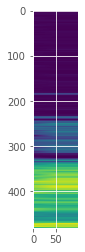

In [89]:
#plt.imshow(interpolate_specgram_sample(bag_a_average_image, 100))
plt.imshow(interpolate_specgram_sample(bag['a'][40], 100))
print(bag['b'][1])